In [1]:
import catboost
import gc
import joblib
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [2]:
from utils.common import (
    sigmoid, 
    pad_column_name
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric,
    TreeExperiment
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols, plot_heatmap, plot_bar,
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)

In [3]:
%load_ext autoreload
%autoreload

In [4]:
%%time
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")
# if "target" not in train.columns:
#     train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 248 ms, sys: 22.9 ms, total: 271 ms
Wall time: 271 ms


### Read Model

In [5]:
%%time
lgbm_dart = TreeExperiment(
    exp_full_path="../experiments/12.lgbm_dart_manual_split_42",
    seed=42, 
    model_path="dart_models"
)

CPU times: user 2.84 s, sys: 1.09 s, total: 3.93 s
Wall time: 729 ms


In [6]:
# lgbm_dart.models[1].params

In [7]:
# lgbm_dart.models[0].feature_name()

In [8]:
result = pd.DataFrame(dict(name=lgbm_dart.models[2].feature_name(),
                           imp=lgbm_dart.models[2].feature_importance()))

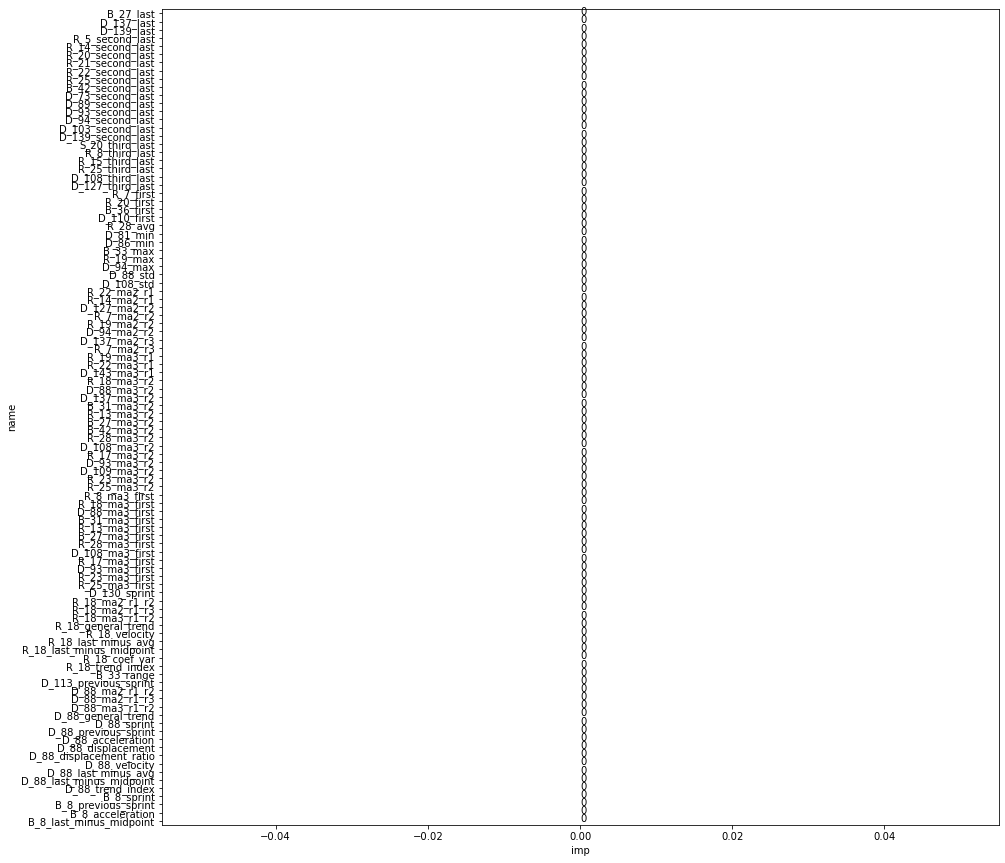

In [9]:
plot_bar(result.nsmallest(100, "imp"), "name", num_col="imp", title=None, horizontal=True, decimal=2, figsize=(15, 15))

In [12]:
# lgbm_dart.feature_imp_summary.to_csv("../experiments/12.lgbm_dart_manual_split_42/feature_importance.csv", index=False)

### Training Inference

In [13]:
%%time
train_agg = read_file(f"{PROCESSED_DATA_PATH}/v6/train_agg.parquet")

Shape of data: (458913, 5064)
CPU times: user 17.5 s, sys: 23.6 s, total: 41.1 s
Wall time: 28.8 s


In [14]:
# del test_agg

In [15]:
# cat_columns = get_cols(train_agg, CATEGORY_COLUMNS)

In [16]:
# pd.DataFrame(dict(feature=lgbm_dart.models[0].feature_name())).to_csv(f"{PROCESSED_DATA_PATH}/v4/feature_list.csv", index=False)

In [17]:
%%time
train_scores_df = lgbm_dart.inference_full(train_agg)

Model 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [02:18<00:00,  1.51s/it]


Model 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [02:17<00:00,  1.49s/it]


Model 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [02:14<00:00,  1.46s/it]


Model 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [02:14<00:00,  1.46s/it]


Model 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [02:12<00:00,  1.44s/it]

CPU times: user 1h 39min 54s, sys: 2min 48s, total: 1h 42min 43s
Wall time: 11min 17s


In [45]:
# train_scores_df.to_csv("../experiments/12.lgbm_dart_manual_split_42/train_scores_df.csv", index=False)

#### If normal stratify K-fold is being use

In [21]:
kf = StratifiedKFold(n_splits=5, random_state=lgbm_dart.seed, shuffle=True)
val_indices = [idx_va for idx_tr, idx_va in kf.split(train_agg, labels["target"])]

In [ ]:
for i in range(5):
    train_scores_df.loc[val_indices[i], "oof_score"] = train_scores_df.loc[val_indices[i], f"score{i+1}"].values

#### If manual split is being use

In [50]:
exp12_val_cids = joblib.load(f"./{EXP_PATH}/12.lgbm_dart_manual_split_42/5fold_val_cid.pkl")

In [51]:
for i in range(5):
    train_scores_df.loc[labels["customer_ID"].isin(exp12_val_cids[i]), "oof_score"] = \
        train_scores_df.loc[labels["customer_ID"].isin(exp12_val_cids[i]), f"score{i+1}"].values

In [25]:
# train_scores_df.insert(5, "target", labels["target"])

In [58]:
train_scores_df.to_csv("../experiments/12.lgbm_dart_manual_split_42/train_scores_df.csv", index=False)

In [54]:
# train_scores_df = read_file("../experiments/11.lgbm_dart_round_clip_7788/train_scores_df.csv")

In [55]:
train_scores_df.describe()

,score1,score2,score3,score4,score5,oof_score
count,458913.000000,458913.000000,458913.000000,458913.000000,458913.000000,458913.000000
mean,-2.701485,-2.709308,-2.704745,-2.706495,-2.694050,-2.703072
std,3.695234,3.703422,3.695250,3.694666,3.691794,3.678417
min,-9.681596,-9.874951,-9.793536,-9.490644,-9.817147,-9.520891
25%,-5.864257,-5.873206,-5.858815,-5.875481,-5.838370,-5.858724
50%,-3.490527,-3.473782,-3.486311,-3.486194,-3.486137,-3.461660
75%,0.314607,0.317671,0.315733,0.318051,0.308858,0.282571
max,9.063671,8.734650,8.781393,8.613000,8.832965,9.063671


In [57]:
# amex_metric_np(train_scores_df["oof_score"], labels["target"])

In [19]:
del train_agg

### Test Inference

In [20]:
%%time
test_agg = read_file(f"{PROCESSED_DATA_PATH}/v6/test_agg.parquet")

Shape of data: (924621, 5062)
CPU times: user 32 s, sys: 42.1 s, total: 1min 14s
Wall time: 1min 1s


In [21]:
test_agg.head()

,P_2_last,S_3_last,P_3_last,S_5_last,S_6_last,S_7_last,S_8_last,S_12_last,S_13_last,S_15_last,...,D_131_previous_sprint,D_131_acceleration,D_131_range,D_131_displacement,D_131_displacement_ratio,D_131_velocity,D_131_last_minus_avg,D_131_last_minus_midpoint,D_131_coef_var,D_131_trend_index
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.56,0.14,0.95,0.01,0,0.15,0.46,0.18,6.0,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.84,0.11,0.91,0.00,0,0.08,0.76,0.19,2.0,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.69,0.16,0.95,0.00,0,0.17,0.12,0.18,NaN,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.51,0.18,1.01,0.32,0,0.55,0.46,0.25,9.0,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,0.25,0.16,0.95,0.06,0,0.11,0.24,0.19,NaN,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
%%time
test_agg = test_agg.reset_index()

CPU times: user 985 ms, sys: 6.86 s, total: 7.84 s
Wall time: 20.6 s


In [23]:
# %%time
# test_agg1 = test_agg1.reset_index()
# test_agg2 = test_agg2.reset_index()

In [24]:
test_scores = lgbm_dart.inference_full(test_agg)
# test_scores2 = lgbm_dart.inference_full(test_agg2)

Model 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [04:50<00:00,  1.57s/it]


Model 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [04:29<00:00,  1.46s/it]


Model 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [04:29<00:00,  1.46s/it]


Model 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [04:28<00:00,  1.45s/it]


Model 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [04:27<00:00,  1.44s/it]


In [25]:
test_scores.shape

(924621, 5)

In [26]:
# test_scores["score2"] = test_scores["score2"] * 0.93

In [27]:
test_scores.describe()

,score1,score2,score3,score4,score5
count,924621.000000,924621.000000,924621.000000,924621.000000,924621.000000
mean,-2.366263,-2.343757,-2.363178,-2.342675,-2.406561
std,3.389239,3.371439,3.390802,3.372530,3.415792
min,-8.946848,-8.905071,-8.925530,-8.891740,-8.988807
25%,-5.262737,-5.214425,-5.239720,-5.221316,-5.312278
50%,-3.038527,-2.990105,-3.027323,-3.013176,-3.102358
75%,0.277992,0.283531,0.275348,0.290552,0.251773
max,8.756742,8.610081,8.535575,8.620824,8.633587


In [28]:
test_scores.head()

,score1,score2,score3,score4,score5
0,-3.208913,-2.858605,-3.017773,-3.152042,-3.274824
1,-6.756111,-6.355837,-6.470542,-6.527915,-6.444073
2,-2.951219,-2.745911,-2.922834,-3.121139,-3.189095
3,-0.405059,-0.814014,-0.485352,-0.560823,-0.317117
4,2.441684,2.131518,2.324856,2.261447,2.535611


In [5]:
# test_scores.to_csv(f"../experiments/12.lgbm_dart_manual_split_42/scores_df.csv", index=False)

In [7]:
t = read_file(f"../experiments/12.lgbm_dart_manual_split_42/scores_df.csv").mean(axis=1)

Shape of data: (924621, 5)


In [9]:
sub = read_file(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = t
sub.to_csv(f"{SUBMISSION_DATA_PATH}/single_5fold_manual_split_42_from_clipped_rounded2.csv", index=False)

Shape of data: (924621, 1)


In [ ]:
fi.loc[(fi["last"] - fi["third_last"]) < -15, ["base_feature", "last", "second_last", "third_last"]]

In [ ]:
fi2.loc[(fi2["last"] - fi2["first"]) < -5, ["base_feature", "last", "second_last", "third_last", "first"]]

In [ ]:
plot_heatmap(fi.corr(), annot=True, figsize=(19, 17), fmt=".2f")

In [ ]:
# %%time
# lgbm_gbdt_shuffled = LGBM(
#     exp_full_path="../experiments/lgbm_gbdt_shuffled_exp"
# )
# gbdt_shuffled_master_feature_set = lgbm_gbdt_shuffled.master_feature_set

In [ ]:
# master_feature_set = sorted(gbdt_master_feature_set.union(
#     gbdt_shuffled_master_feature_set
# ))
# len(set(master_feature_set))

### Read Train Data (Error Analysis)

In [ ]:
labels = read_file(f"{RAW_DATA_PATH}/train_labels.csv")

In [ ]:
target = labels["target"]

In [ ]:
%%time
raw_train = read_file(f"{RAW_TRAIN_PICKLE_PATH}/raw_train_data.pkl")

In [ ]:
%%time
train_agg = train_agg.loc[:, list(gbdt_master_feature_set)]

In [ ]:
%%time
train_agg = lgbm_gbdt.inference_fold(train_agg, target)

In [ ]:
train_agg.head()

In [ ]:
%%time
eval_df = get_final_metric_df(train_agg.iloc[:, :-1], target, train_agg["prediction"])

In [ ]:
eval_df.loc[eval_df["is_cutoff"] == 1, "target"].sum() / eval_df["target"].sum()

In [ ]:
%%time
false_negative_indices = eval_df.loc[(eval_df["target"] == 1) & (eval_df["is_cutoff"] == 0)].index.tolist()
false_positive_indices = eval_df.loc[(eval_df["target"] == 0) & (eval_df["is_cutoff"] == 1)].index.tolist()

In [ ]:
len(false_negative_indices), len(false_positive_indices)

In [ ]:
wrong_indices = eval_df.loc[false_negative_indices + false_positive_indices, :].index.tolist()

In [ ]:
len(wrong_indices)

In [ ]:
%%time
summary_count_df = raw_train.groupby("customer_ID").count()
summary_count_df = summary_count_df.reset_index()

In [ ]:
for col in tqdm(summary_count_df.columns[4:]):
    summary_count_df[col] = 1 - (summary_count_df[col] / summary_count_df["row_number"])

In [ ]:
wrong_pred_missing_count_df = summary_count_df.loc[wrong_indices]
wrong_pred_missing_count_df = wrong_pred_missing_count_df.sort_index()
correct_pred_missing_count_df = summary_count_df.loc[~summary_count_df.index.isin(wrong_indices)]

In [ ]:
correct_mean_df = correct_pred_missing_count_df.iloc[:, 3:].mean()

In [ ]:
wrong_mean_df = wrong_pred_missing_count_df.iloc[:, 3:].mean()

In [ ]:
((wrong_mean_df / correct_mean_df - 1).sort_values(ascending=False) > 0).sum()

In [ ]:
((wrong_mean_df / correct_mean_df - 1).sort_values(ascending=False) < 0).sum()

In [ ]:
(wrong_mean_df / (correct_mean_df + wrong_mean_df)).sort_values(ascending=False).to_csv(
    f"{EXP_PATH}/percent_of_missing_from_wrong.csv"
)

In [ ]:
wrong_mean_df["D_124"], correct_mean_df["D_124"]

In [ ]:
train_, test_ = train_test_split(score_df, test_size=0.2, random_state=1020)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression()
logreg.fit(train_.drop(columns="target"), train_["target"])

In [ ]:
y_pred = logreg.predict_proba(test_.drop(columns="target"))[:, 1]

In [ ]:
y_true = test_["target"].values

In [ ]:
amex_metric(y_true, y_pred)

In [ ]:
# del train_agg

In [ ]:
# lgbm_gbdt.run_validation_check(data=train_agg, labels=labels["target"].values)

In [ ]:
lgbm_gbdt.val_metrics

In [ ]:
# train_agg = lgbm_dart.run_validation_check(data=train_agg)

In [ ]:
# lgbm_dart.val_metrics

### Error Analysis

In [ ]:
train_agg.loc[train_agg["target"] == 0, "prediction"].describe()

In [ ]:
train_agg.loc[train_agg["target"] == 1, "prediction"].describe()

### High Pred Score Analysis

In [ ]:
success_pos_df = train_agg.loc[
    (train_agg["target"] == 1) & (train_agg["is_cutoff"] == 1)
]

In [ ]:
fail_neg_df = train_agg.loc[
    (train_agg["target"] == 0) & (train_agg["is_cutoff"] == 1)
]

### Low Pred Score Analysis

In [ ]:
success_neg_df = train_agg.loc[
    (train_agg["target"] == 0) & (train_agg["is_cutoff"] == 0)
]

In [ ]:
fail_pos_df = train_agg.loc[
    (train_agg["target"] == 1) & (train_agg["is_cutoff"] == 0)
]

In [ ]:
success_neg_df["num_statements"].describe()

In [ ]:
fail_pos_df["num_statements"].describe()

In [ ]:
base_feature = "P_2"

In [ ]:
# for col in get_cols(success_neg_df, base_feature):
#     my_dict = {
#         'True Negative': success_neg_df[col].dropna().values, 
#         'False Negative': fail_pos_df[col].dropna().values,
#         'True Positive': success_pos_df[col].dropna().values, 
#     }
#     fig, ax = plt.subplots(figsize=(15, 12))
#     ax.boxplot(my_dict.values())
#     ax.set_xticklabels(my_dict.keys())
#     plt.title(f"{col}")
#     plt.show()

In [ ]:
# success_pos_df.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp3/success_positive.pkl")
# fail_pos_df.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp3/failed_positive.pkl")
# success_neg_df.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp3/success_negative.pkl")
# fail_neg_df.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp3/failed_negative.pkl")

### Read Test Data

In [ ]:
%%time
if 'train_agg' in locals():
    del train_agg
# test_agg = read_file(f"{PROCESSED_DATA_PATH}/test_agg_complete2.pkl")
test_agg = read_file(f"{PROCESSED_DATA_PATH}/test_agg.pkl")
gc.collect()

In [ ]:
%%time
test_agg = test_agg.loc[:, list(gbdt_master_feature_set)]
test_agg.shape

In [ ]:
# lgbm_gbdt.feature_imp_df.iloc[30:60]

In [ ]:
%%time
scores_list = []
batch_size = 5000
for j, model in enumerate(lgbm_gbdt.models.values()):
    score_list = []
    print(f"Model {j + 1}")
    for i in tqdm(range(int(test_agg.shape[0] / batch_size) + 1)):
        score_list.append(model.predict(
            test_agg.loc[int(i*batch_size): int((i+1)*batch_size) - 1, model.feature_name()], 
            raw_score=True
        ))
    scores_list.append(np.concatenate(score_list))

In [ ]:
with open(f"{lgbm_gbdt.path}/best_scores.json", "r+") as outfile:
    best_scores_json = json.load(outfile)
np.mean(list(best_scores_json["validation"].values()))

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# score_df = pd.DataFrame(np.array(scores_list).T, columns=range(1, 6))
# minmax_scaler = MinMaxScaler()
# score_df = pd.DataFrame(minmax_scaler.fit_transform(score_df), columns=range(1, 6))
# score_df.describe()
# test_agg["prediction"] = np.mean(score_df, axis=1) 

In [ ]:
test_agg["prediction"] = np.mean(scores_list, axis=0)

In [ ]:
# test_score_df.applymap(sigmoid).mean(axis=1).values # 

In [ ]:
test_score_df = pd.DataFrame(np.array(scores_list).T, columns=[f"score{i}" for i in range(1, 6)])

In [ ]:
submission = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission25_0.799.csv")
# submission["prediction"] = test_agg["prediction"].values
submission["prediction"] = test_score_df.applymap(sigmoid).mean(axis=1)
submission.to_csv(f"{SUBMISSION_DATA_PATH}/submission6_0.797055_sigmoid_avg.csv", index=False)

In [ ]:
# test_agg = lgbm_dart.get_test_prediction(test_agg)

In [ ]:
# submission["prediction"].apply(sigmoid)

In [ ]:
test_score_df

#### Take the average of all CV models' predictions

In [ ]:
# np.mean(scores_list, axis=0)

In [ ]:
test_agg["prediction"] = np.mean(scores_list, axis=0)

In [ ]:
def get_metric_columns(df):
    df = df.sort_values(by="prediction", ascending=False)
    df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
    four_pct_cutoff = int(0.04 * df['weight'].sum())
    df['weight_cumsum'] = df['weight'].cumsum()
    df["is_cutoff"] = 0
    df.loc[df['weight_cumsum'] <= four_pct_cutoff, "is_cutoff"] = 1
    df = df.reset_index()
    
    df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
    total_pos = (df['target'] * df['weight']).sum()
    df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
    df['lorentz'] = df['cum_pos_found'] / total_pos
    df['gini'] = (df['lorentz'] - df['random']) * df['weight']
    return df

In [ ]:
test_agg["prediction"].describe()

In [ ]:
del scores_list

In [ ]:
test_agg.loc[(test_agg["P_2_last"] < 0.4) & (test_agg["prediction"] < 0), "prediction"] += 4

#### Take a look on CV score

In [ ]:
with open(f"{EXP_FULL_PATH}/best_scores.json", "r+") as outfile:
    best_scores = json.load(outfile)
np.mean(list(best_scores["validation"].values()))

### Manual Adjustment

In [ ]:
test_agg["P_2_last"].describe()

#### Prepare the submission csv, then export out new submission file

In [ ]:
submission = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission25_0.799.csv")
submission["prediction"] = test_agg["prediction"].values
submission.to_csv(f"{SUBMISSION_DATA_PATH}/submission__.csv", index=False)

### Analyze Feature Importance

#### Read old feature importance summary df

In [ ]:
old_feature_imp_df = pd.read_csv(f"{EXP_FULL_PATH}/feature_imp_summary.csv")

#### Construct new feature importance summary df

In [ ]:
feature_imp_df.loc[feature_imp_df["agg_type"] == ""]

In [ ]:
corr_df = pd.read_csv(f"{PROCESSED_DATA_PATH}/raw_column_correlation/train_corr_df.csv")
base_features = corr_df.columns.tolist()

In [ ]:
old_feature_imp_df

In [ ]:
new_feature_imp_df.to_csv(f"{PROCESSED_DATA_PATH}/feature_imp_summary.csv", index=False)

In [ ]:
# validation_indices = joblib.load(f'{EXP_FULL_PATH}/5_fold_val_indices.pkl')

## Feature Importance

In [ ]:
# fi_master = read_file(f"{EXP_PATH}/feature_imp_general_summary.csv")

In [ ]:
fi_gbdt = lgbm_gbdt2.feature_imp_summary

In [ ]:
# fi_gbdt.to_csv(f"{EXP_PATH}/feature_imp_summary5.csv", index=False)

In [ ]:
fi_dart = lgbm_dart.feature_imp_df

In [ ]:
lgbm_gbdt.feature_imp_summary.to_csv(f"{EXP_PATH}/feature_imp_summary3.csv", index=False)

In [ ]:
lgbm_gbdt_shuffled.feature_imp_df.groupby("agg_type")["average_importance"].sum().sort_values().iloc[-30:]

In [ ]:
set(fi_gbdt["base_feature"]) - set(fi_dart["base_feature"])

In [ ]:
set(fi_dart["base_feature"]) - set(fi_gbdt["base_feature"])

In [ ]:
# lgbm_dart.feature_imp_df

In [ ]:
imp_df = lgbm_gbdt.feature_imp_df.copy()
imp_summary = lgbm_gbdt.feature_imp_summary.copy()

In [ ]:
half_max_imp_df = imp_df.loc[imp_df["average_importance"] > 0.5*imp_df["average_importance"].max()]

In [ ]:
top_base_features = imp_summary.loc[imp_summary["base_feature"].isin(half_max_imp_df["base_feature"].tolist())]

In [ ]:
plot_heatmap(top_base_features.set_index("base_feature"), annot=True, figsize=(18, 18), fmt=".1f")

In [ ]:
lgbm_gbdt.feature_imp_summary.to_csv(f"{EXP_PATH}/feature_imp_summary3.csv", index=False)

In [ ]:
noob_features_df = feature_imp_df["average_importance"].nsmallest(int(feature_imp_df.shape[0] * 0.04))
noob_features = noob_features_df.index.tolist()

In [ ]:
top_features_df = feature_imp_df["average_importance"].nlargest(int(feature_imp_df.shape[0] * 0.9))
top_features = top_features_df.index.tolist()

In [ ]:
pd.Series([f.split("_")[-1] for f in top_features]).value_counts()

In [ ]:
pd.Series(top_features, name="feature").to_csv("top_features.csv", index=False)

In [ ]:
# used_features = set(feature_imp_df.index.tolist())

In [ ]:
mean_features = pad_column_name(MEAN_FEATURES, suffix="_avg")
min_features = pad_column_name(MIN_FEATURES, suffix="_min")
max_features = pad_column_name(MAX_FEATURES, suffix="_max")
last_features = pad_column_name(LAST_FEATURES, suffix="_last")
first_features = pad_column_name(FIRST_FEATURES, suffix="_first")

In [ ]:
range_features = pad_column_name(RANGE_FEATURES, suffix="_range")
velocity_features = pad_column_name(VELOCITY_FEATURES, suffix="_velocity")
speed_features = pad_column_name(SPEED_FEATURES, suffix="_speed")

In [ ]:
all_features = (
    mean_features + min_features + max_features + last_features + first_features
    + range_features + velocity_features + speed_features
)

In [ ]:
len(all_features)

In [ ]:
set(top_features) - set(all_features)

In [ ]:
top_features

In [ ]:
feature_imp_df = feature_imp_df.loc[feature_imp_df["average_importance"] > 0]
feature_imp_subset = feature_imp_df.loc[feature_imp_df["average_importance"] > 200].reset_index()

In [ ]:
# feature_imp_subset.loc[feature_imp_subset["feature"].str.contains("last")].sort_values("feature")

In [ ]:
t = feature_imp_subset.copy()

In [ ]:
t.loc[t["feature"] == "D_128_first"]

In [ ]:
# feature_imp_df.index.tolist()

In [ ]:
feature_list = feature_imp_df.index.tolist()
len(feature_list)

In [ ]:
original_score

In [ ]:
simulated_score_list = []
for feature in feature_list[::-1]:
    temp_train_val = train_val.copy()
    temp_train_val[feature] = np.nan
    for i, indices in enumerate(validation_indices):
        temp_model = models[i]
        temp_val = temp_train_val.loc[indices, temp_model.feature_name_]
        temp_train_val.loc[indices, "score"] = temp_model.predict_proba(temp_val, raw_score=True)
    simulated_score = amex_metric(temp_train_val["target"], temp_train_val["score"])
    simulated_score_list.append(simulated_score)
    if simulated_score >= original_score:
        sign = "+"
    else:
        sign = ""
    if abs(simulated_score - original_score) >= 1e-4:
        print(feature, f" {sign}{(simulated_score - original_score):.4f}")
    print(f"{feature} done")
    del temp_train_val
    gc.collect()

In [ ]:
test = read_file(f"{RAW_TEST_PICKLE_PATH}/test_data.pkl")

In [ ]:
test.loc[test["row_number"] > 12]

In [ ]:
test_agg = process_test_data(test)

In [ ]:
test_agg.head()

In [ ]:
del test

In [ ]:
for i, model in enumerate(models.values()):
    model_input = test_agg.loc[:, model.feature_name_]
    test_agg.loc[:, f"score{i}"] = model.predict_proba(model_input, raw_score=True)

In [ ]:
test_agg.head()

In [ ]:
new_result_sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission19_0.796.csv")

In [ ]:
old_result_sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission17_0.796.csv")

In [ ]:
plt.scatter(old_result_sub["prediction"], new_result_sub["prediction"])

In [ ]:
np.corrcoef(old_result_sub["prediction"], new_result_sub["prediction"])

In [ ]:
merged_result = new_result_sub.merge(old_result_sub, on="customer_ID", how="left")

In [ ]:
merged_result["x_positive"] = (merged_result["prediction_x"] >= 0)

In [ ]:
merged_result["y_positive"] = (merged_result["prediction_y"] >= 0)

In [ ]:
neg_neg_indices = merged_result.loc[(~merged_result["x_positive"]) & (~merged_result["y_positive"])].index

In [ ]:
merged_result.loc[neg_neg_indices, "prediction"] = merged_result.loc[neg_neg_indices, :].min(axis=1)

In [ ]:
pos_pos_indices = merged_result.loc[(merged_result["x_positive"]) & (merged_result["y_positive"])].index

In [ ]:
merged_result.loc[pos_pos_indices, "prediction"] = merged_result.loc[pos_pos_indices, :].max(axis=1)

In [ ]:
merged_result["prediction"].isnull().sum()

In [ ]:
merged_result.loc[merged_result["prediction"].isnull(), "prediction"] = \
(merged_result.loc[merged_result["prediction"].isnull(), "prediction_x"] + \
merged_result.loc[merged_result["prediction"].isnull(), "prediction_y"]) / 2

In [ ]:
merged_result = merged_result.drop(columns=["prediction_x", "prediction_y", "x_positive", "y_positive"])

In [ ]:
merged_result.to_csv(f"{SUBMISSION_DATA_PATH}/submission23.csv", index=False)

In [ ]:
new_result_sub["prediction"] = np.max([new_result_sub["prediction"].values, old_result_sub["prediction"].values], axis=0)

In [ ]:
new_result_sub["prediction"] += old_result_sub["prediction"]

In [ ]:
new_result_sub["prediction"] /= 2

In [ ]:
new_result_sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission22.csv", index=False)

In [ ]:
result_sub = test_agg.loc[:, [c for c in test_agg.columns if c.startswith("score")]].mean(axis=1).reset_index()

In [ ]:
result_sub.columns = ["customer_ID", "prediction"]

In [ ]:
result_sub.to_csv("submission20.csv", index=False)

In [ ]:
single_record_index = test_agg.loc[test_agg["num_records"] == 1].index.tolist()

In [ ]:
final_df13 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission13_0.796.csv")
final_df13["prediction_13"] = sigmoid(final_df13["prediction"])
final_df13 = final_df13.drop(columns="prediction")

In [ ]:
final_df16 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission16_0.782.csv")
final_df16["prediction_16"] = sigmoid(final_df16["prediction"])
final_df16 = final_df16.drop(columns="prediction")

In [ ]:
mega_df = final_df13.merge(final_df16, on="customer_ID", how="left")

In [ ]:
mega_df.loc[:, "prediction"] = (
    mega_df.loc[:, "prediction_16"] * 0.1 \
    + mega_df.loc[:, "prediction_13"] * 0.9
)

In [ ]:
mega_df.loc[single_record_index, "prediction"] = (
    mega_df.loc[single_record_index, "prediction_16"] * 0.8 \
    + mega_df.loc[single_record_index, "prediction_13"] * 0.2
)

In [ ]:
mega_df = mega_df.drop(columns=["prediction_13", "prediction_16"])

In [ ]:
mega_df["prediction"] = 0.55 * mega_df["prediction_x"] + 0.45 * mega_df["prediction_y"]
mega_df = mega_df.drop(columns=["prediction_x", "prediction_y"])

In [ ]:
mega_df.to_csv(f"{SUBMISSION_DATA_PATH}/submission18.csv", index=False)